In [1]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00


In [1]:
# Code to log in to the Hugging Face Hub, needed for sharing models
# Make sure you use a token with WRITE access
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [3]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.35.2",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

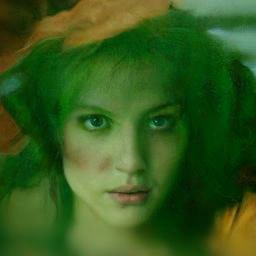

In [7]:
images = image_pipe().images
images[0]

In [6]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

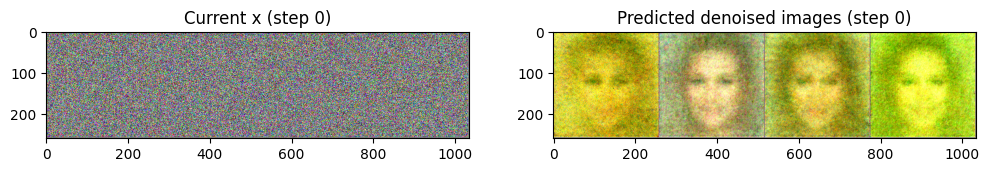

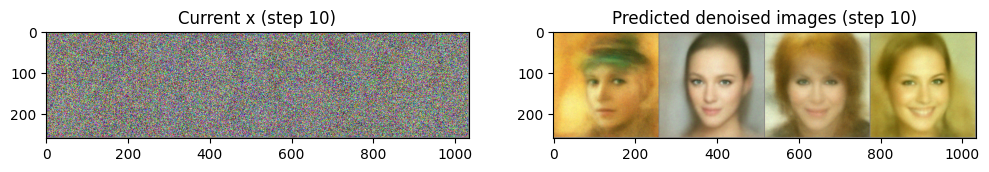

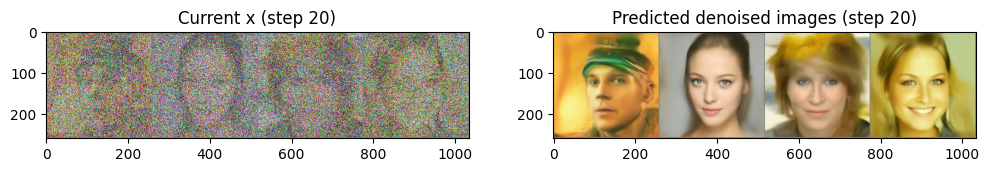

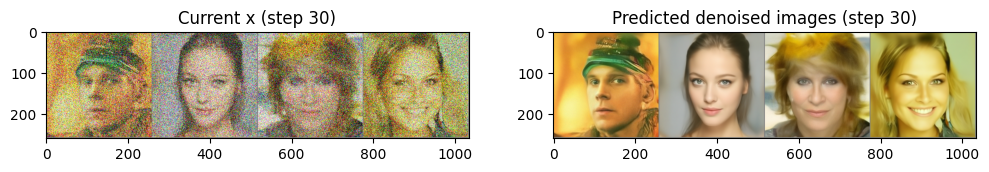

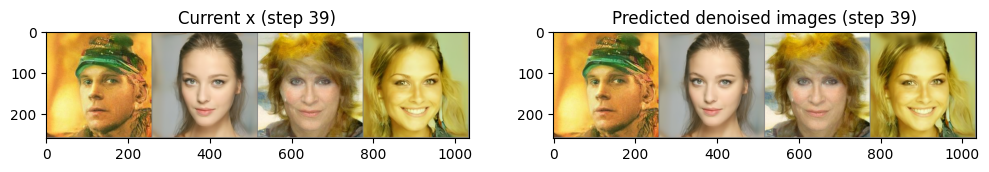

In [9]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

In [24]:
??scheduler.step

  0%|          | 0/40 [00:00<?, ?it/s]

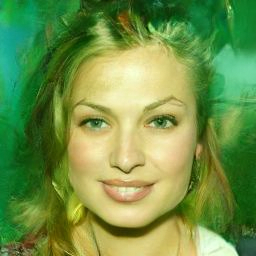

In [12]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Previewing batch:


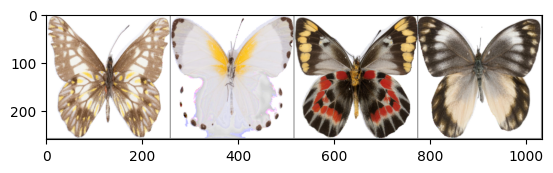

In [9]:
# @markdown load and prepare a dataset:
# Not on Colab? Comments with #@ enable UI tweaks like headings or user inputs
# but can safely be ignored if you're working on a different platform.

dataset_name = "huggan/smithsonian_butterflies_subset"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.015966117066680455


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.011847630805452354


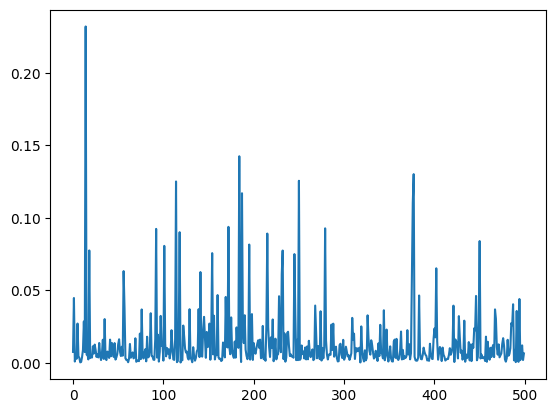

In [10]:
num_epochs = 2  # @param
lr = 1e-5  # 2param
grad_accumulation_steps = 2  # @param

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# Plot the loss curve:
plt.plot(losses)

0it [00:00, ?it/s]

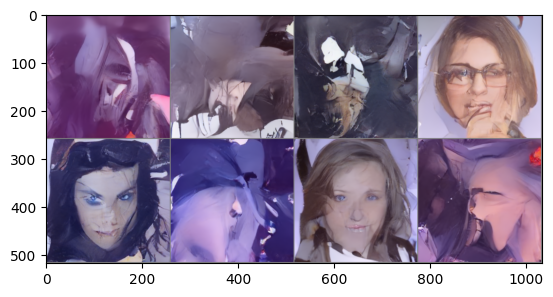

In [11]:
# @markdown Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [12]:
image_pipe.save_pretrained("my-finetuned-model")

In [13]:
!ls {"my-finetuned-model"}

model_index.json  scheduler  unet


In [18]:
# @title Upload a locally saved pipeline to the hub

# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
model_name = "ddpm-celebahq-finetuned-butterflies-2epochs"  # @param What you want it called on the hub
local_folder_name = ("my-finetuned-model")
description = "First time fine tune diffusion model"  # @param
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id)
api.upload_folder(folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

# Add a model card (optional but nice!)
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}
"""

## Usage

from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image

HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-691e7f06-3d24ec68558253460fc679f7;ce780e99-65d1-4cb8-aaa5-29b67e8f5839)

You already created this model repo: kaaiiii/ddpm-celebahq-finetuned-butterflies-2epochs

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

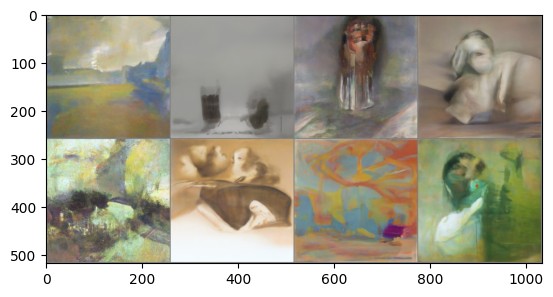

In [19]:



# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [21]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = torch.tensor(target_color).to(images.device) * 2 - 1  # Map target color to (-1, 1)
    target = target[None, :, None, None]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(images - target).mean()  # Mean absolute difference between the image pixels and the target color
    return error

0it [00:00, ?it/s]

0 loss: 29.669349670410156
10 loss: 12.317092895507812
20 loss: 11.637482643127441
30 loss: 11.739751815795898


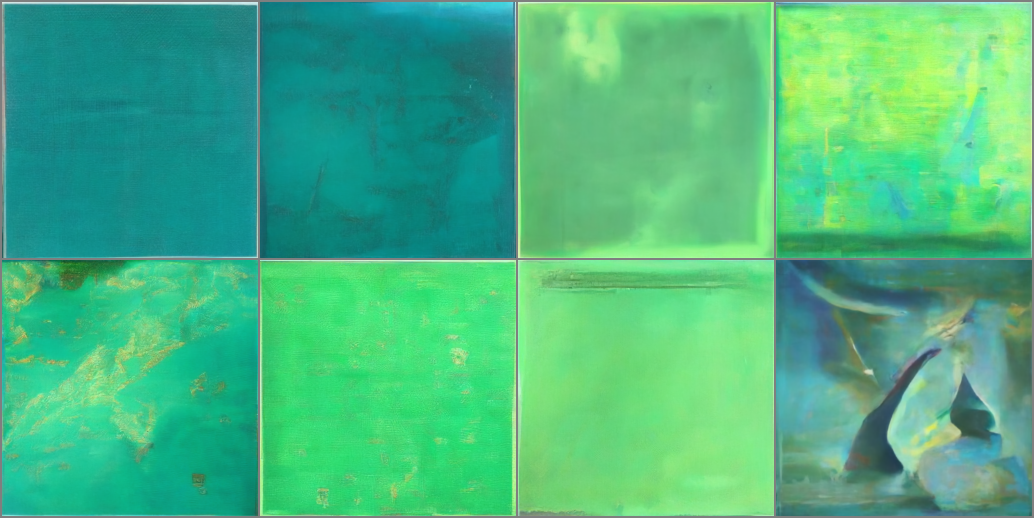

In [22]:
# Variant 1: shortcut method

# The guidance scale determines the strength of the effect
guidance_loss_scale = 40  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

0it [00:00, ?it/s]

0 loss: 28.841856002807617
10 loss: 21.663589477539062
20 loss: 19.939416885375977
30 loss: 19.996557235717773


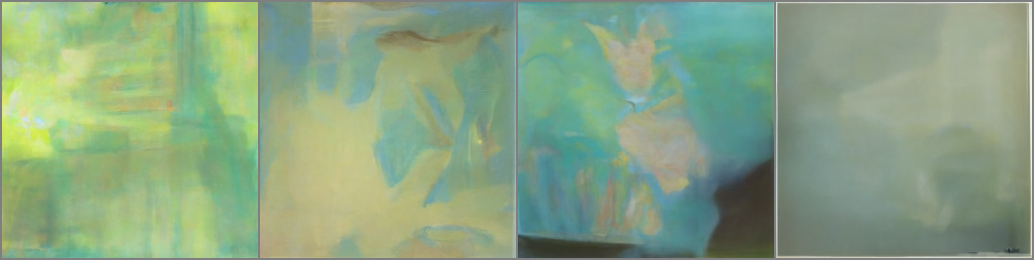

In [23]:
# Variant 2: setting x.requires_grad before calculating the model predictions

guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))